## Land Data Processing Notebook
The purpose of this notebook is to test out how to pre-process land data which will be used to construct land obstacles at runtime in deployment.

## Data Source and License for Use
This notebook uses OSM data downloaded from here: https://osmdata.openstreetmap.de/data/land-polygons.html

The data set used is the one described with "Large polygons are split, use for larger zoom levels"

This data may be used for ANY purpose under the Open Database License (ODbL) v1.0. https://www.openstreetmap.org/copyright

In [1]:
import os
import pickle
from typing import Any
import random
import time

import numpy as np
import geopandas as gpd
import plotly.graph_objects as go
from numpy import ndarray
from shapely.geometry import box, MultiPolygon, Point

from custom_interfaces.msg import (
    HelperAISShip,
    HelperDimension,
    HelperHeading,
    HelperLatLon,
    HelperROT,
    HelperSpeed,
)

from local_pathfinding.coord_systems import (
    XY,
    latlon_to_xy,
    latlon_polygon_list_to_xy_polygon_list,
    meters_to_km,
)
from local_pathfinding.obstacles import BOAT_BUFFER, Boat, Land, Obstacle

### Helper Functions

In [2]:
def dump_pkl(object: Any, file_path: str):
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, "wb") as f:
        pickle.dump(object, f, protocol=pickle.HIGHEST_PROTOCOL)


def load_pkl(file_path: str) -> Any:
    with open(file_path, "rb") as f:
        return pickle.load(f)

### Load Initial Data Set
This dataset is derived from the source listed above but has been clipped to only include polygons along the pacific coast.
Any polygons not in the pacific region in which we plan to sail were excluded, as were most inland polygons.

In [3]:
gdf = gpd.read_file("shp/complete_land_data.shp")

### Explore Data Set

In [4]:
print(f"gdf has {len(gdf)} rows (polygons)")
print(gdf.crs)
gdf.head()

gdf has 58826 rows (polygons)
epsg:4326


,FID,geometry
0,0,"POLYGON ((-109.69245 27.05423, -109.69245 29.5..."
1,1,"POLYGON ((-161.68308 55.91480, -161.68165 55.9..."
2,2,"POLYGON ((-161.36932 55.95919, -161.36859 55.9..."
3,3,"POLYGON ((-161.17767 55.99920, -161.17666 56.0..."
4,4,"POLYGON ((-161.17863 55.99875, -161.17904 55.9..."


### Explore Map of Data
The line below produces an interactive map of the entire land polygons data set we are working with, which is very large and this map makes the notebook lag significantly.

Instead of showing the actual map, I have commented out the line of code and just pasted a screenshot of the map it produces.

In [5]:
# gdf.explore()

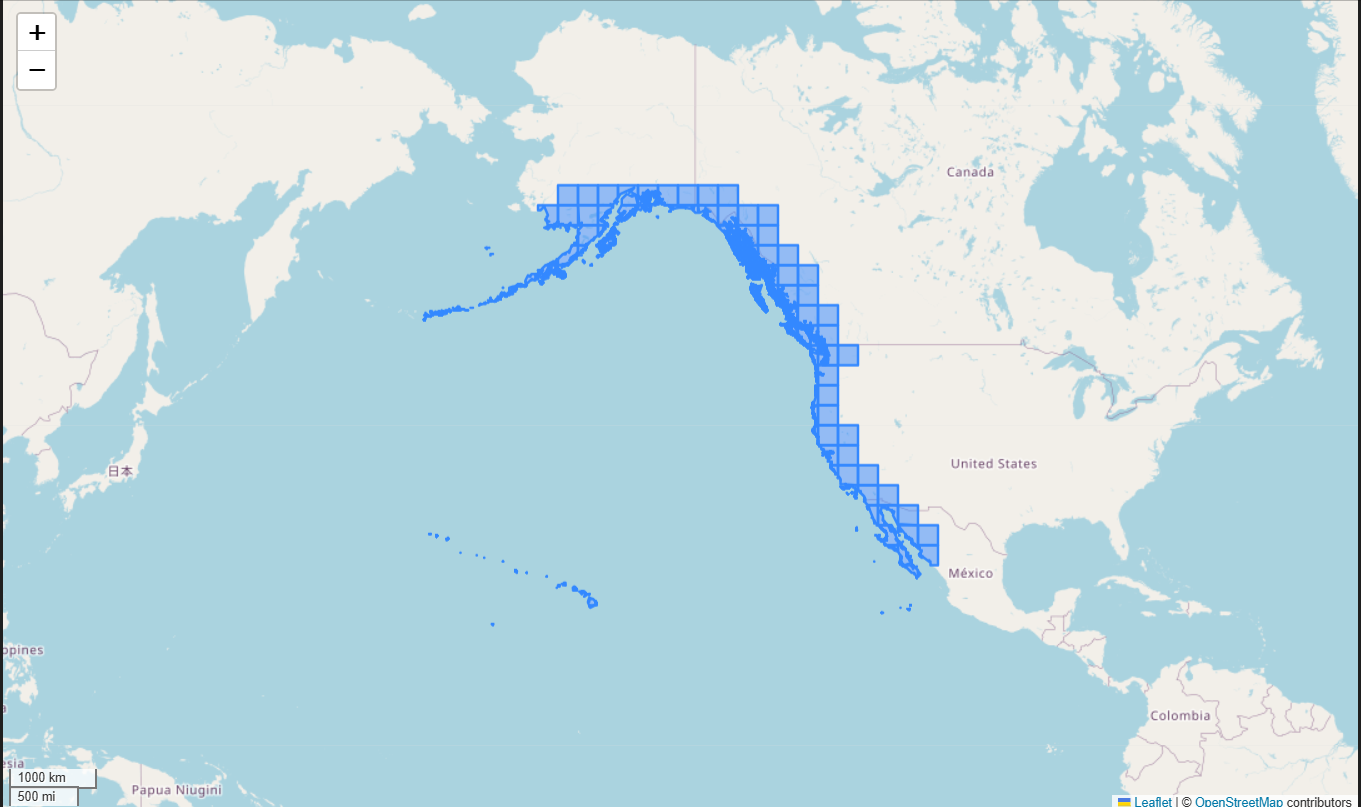

Visual Verification of Creating Boat Object

In [6]:
# Sample AIS SHIP message
ais_ship = HelperAISShip(
    id=1,
    lat_lon=HelperLatLon(latitude=51.97917631092298, longitude=-137.1106454702385),
    cog=HelperHeading(heading=0.0),
    sog=HelperSpeed(speed=18.52),
    width=HelperDimension(dimension=20.0),
    length=HelperDimension(dimension=100.0),
    rot=HelperROT(rot=0),
)

# Create a boat object
boat1 = Boat(
    HelperLatLon(latitude=52.268119490007756, longitude=-136.9133983613776),
    HelperLatLon(latitude=51.95785651405779, longitude=-136.26282894969611),
    30.0,
    ais_ship,
)

# Choose some states for visual inspection
valid_state = HelperLatLon(latitude=50.42973337261916, longitude=-134.12018940923838)
invalid_state = HelperLatLon(latitude=52.174842845359755, longitude=-137.10372451905042)

# Extract coordinates for sailbot
sailbot_x, sailbot_y = boat1.sailbot_position
sailbot = go.Scatter(x=[sailbot_x], y=[sailbot_y], mode="markers", name="Sailbot Position")

fig1 = go.Figure(sailbot)

# Extract coordinates for valid and invalid states
valid_state_x, valid_state_y = latlon_to_xy(boat1.reference, valid_state)
valid_state = go.Scatter(x=[valid_state_x], y=[valid_state_y], mode="markers", name="Valid State")

fig1.add_trace(valid_state)

invalid_state_x, invalid_state_y = latlon_to_xy(boat1.reference, invalid_state)
invalid_state = go.Scatter(
    x=[invalid_state_x], y=[invalid_state_y], mode="markers", name="Invalid State"
)

fig1.add_trace(invalid_state)

# Extract exterior coordinates for boat1's collision cone
if boat1.collision_zone is not None:
    boat_x, boat_y = np.array(boat1.collision_zone.exterior.coords.xy)
    boat_x = np.array(boat_x)
    boat_y = np.array(boat_y)
    boat = go.Scatter(x=boat_x, y=boat_y, fill="toself", name="Boat Collision Cone")
    fig1.add_trace(boat)

# Manually calculate the length of the collision zone based on:
# - the boat's projected distance
# - the boat's length
# - the safety buffer
collision_zone_length = round(
    (
        boat1._calculate_projected_distance()
        + 2 * BOAT_BUFFER
        + meters_to_km(boat1.ais_ship.length.dimension)
    ),
    4,
)

fig1.add_annotation(
    text="Calculated Length of Collision Zone : " + str(collision_zone_length) + " km",
    align="center",
    showarrow=False,
    xref="paper",
    yref="paper",
    x=1,
    y=1,
    bordercolor="black",
    borderwidth=1,
)

# Measure the length of the collision zone based on the points of the polygon
x: ndarray
y: ndarray

if boat1.collision_zone is not None:
    x, y = boat1.collision_zone.exterior.coords.xy

mid_1 = Point((x[1] + x[2]) / 2, (y[1] + y[2]) / 2)
mid_2 = Point((x[0] + x[3]) / 2, (y[0] + y[3]) / 2)

length = round(mid_1.distance(mid_2), 4)

fig1.add_annotation(
    text="Measured Length of Collision Zone : " + str(length) + " km",
    align="center",
    showarrow=False,
    xref="paper",
    yref="paper",
    x=0.7,
    y=1,
    bordercolor="black",
    borderwidth=1,
)

fig1.update_layout(yaxis_range=[-200, 200], xaxis_range=[-200, 750])
fig1

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Sailbot Position',
              'type': 'scatter',
              'x': [44.72138045051051],
              'y': [-34.32228178279231]},
             {'mode': 'markers',
              'name': 'Valid State',
              'type': 'scatter',
              'x': [198.4564937198273],
              'y': [-200.73457454967556]},
             {'mode': 'markers',
              'name': 'Invalid State',
              'type': 'scatter',
              'x': [-13.020228177797499],
              'y': [-10.361941515463219]},
             {'fill': 'toself',
              'name': 'Boat Collision Cone',
              'type': 'scatter',
              'x': {'bdata': 'TTYYZA+dK8AmVmmahvktwI57fb+bPCjAZ5vO9RKZKsBNNhhkD50rwA==', 'dtype': 'f8'},
              'y': {'bdata': 'nvdDKVI3QMBMq5OmDZguQEyrk6YNmC5AnvdDKVI3QMCe90MpUjdAwA==', 'dtype': 'f8'}}],
    'layout': {'annotations': [{'align': 'center',
                                'bordercolor': 'black',
                                'borderwidth': 1,
                                'showarrow': False,
                                'text': 'Calculated Length of Collision Zone : 47.7292 km',
                                'x': 1,
                                'xref': 'paper',
                                'y': 1,
                                'yref': 'paper'},
                               {'align': 'center',
                                'bordercolor': 'black',
                                'borderwidth': 1,
                                'showarrow': False,
                                'text': 'Measured Length of Collision Zone : 47.7292 km',
                                'x': 0.7,
                                'xref': 'paper',
                                'y': 1,
                                'yref': 'paper'}],
               'template': '...',
               'xaxis': {'range': [-200, 750]},
               'yaxis': {'range': [-200, 200]}}
})

Visual Verification of Creating Land Object

In [7]:
LAND = load_pkl("/workspaces/sailbot_workspace/src/local_pathfinding/land/pkl/land.pkl")

reference_point = HelperLatLon(latitude=49.239657, longitude=-123.937798)
sailbot_position = HelperLatLon(latitude=49.217641, longitude=-123.862782)
bbox_buffer_amount = 0.02

sailbot_box = Point(sailbot_position.longitude, sailbot_position.latitude).buffer(
    bbox_buffer_amount, cap_style=3, join_style=2
)
waypoint_box = Point(reference_point.longitude, reference_point.latitude).buffer(
    bbox_buffer_amount, cap_style=3, join_style=2
)

state_space_latlon = box(*MultiPolygon([sailbot_box, waypoint_box]).bounds)

# create the land object
land = Land(
    reference=reference_point,
    sailbot_position=sailbot_position,
    all_land_data=LAND,
    state_space_latlon=state_space_latlon,
)

sailbot_box_xy = latlon_polygon_list_to_xy_polygon_list([sailbot_box], reference_point)[0]
waypoint_box_xy = latlon_polygon_list_to_xy_polygon_list([waypoint_box], reference_point)[0]
state_space_xy = latlon_polygon_list_to_xy_polygon_list([state_space_latlon], reference_point)[0]

# Choose some states for visual inspection
valid_state = HelperLatLon(latitude=49.21503, longitude=-123.91475)
invalid_state = HelperLatLon(latitude=49.21503, longitude=-123.9481)

# Extract coordinates for valid and invalid states
valid_state_x, valid_state_y = latlon_to_xy(reference_point, valid_state)
valid_state = go.Scatter(
    x=[valid_state_x],
    y=[valid_state_y],
    mode="markers",
    name="Valid State",
    fillcolor="green",
)

invalid_state_x, invalid_state_y = latlon_to_xy(reference_point, invalid_state)
invalid_state = go.Scatter(
    x=[invalid_state_x], y=[invalid_state_y], mode="markers", name="Invalid State", fillcolor="red"
)

fig1 = go.Figure(valid_state)
fig1.add_trace(invalid_state)

# add sailbot position to the plot
sailbot_x, sailbot_y = latlon_to_xy(reference_point, sailbot_position)
sailbot = go.Scatter(
    x=[sailbot_x],
    y=[sailbot_y],
    mode="markers",
    name="Sailbot Position",
    fillcolor="rgba(0, 255, 0, 1)",
)
fig1.add_trace(sailbot)

# add next waypoint to the plot
waypoint_x, waypoint_y = latlon_to_xy(reference_point, reference_point)  # (0,0)
waypoint = go.Scatter(
    x=[waypoint_x],
    y=[waypoint_y],
    mode="markers",
    name="Next Waypoint",
    fillcolor="rgba(0, 100, 255, 1)",
)
fig1.add_trace(waypoint)

# add sailbot box to the plot
sailbot_box_x, sailbot_box_y = np.array(sailbot_box_xy.exterior.coords.xy)
sailbot_box = go.Scatter(
    x=sailbot_box_x,
    y=sailbot_box_y,
    fill="toself",
    name="Sailbot Box",
    fillcolor="rgba(0, 255, 0, 0.1)",
    line=dict(width=1, color="rgba(0, 255, 0, 1)"),
    marker=dict(opacity=0),
)
fig1.add_trace(sailbot_box)

# add waypoint box to the plot
waypoint_box_x, waypoint_box_y = np.array(waypoint_box_xy.exterior.coords.xy)
waypoint_box = go.Scatter(
    x=waypoint_box_x,
    y=waypoint_box_y,
    fill="toself",
    name="Waypoint Box",
    fillcolor="rgba(0, 100, 255, 0.1)",
    line=dict(width=1, color="rgba(0, 100, 255, 1)"),
    marker=dict(opacity=0),
)
fig1.add_trace(waypoint_box)

# add bounding box to the plot
bbox_x, bbox_y = np.array(state_space_xy.exterior.coords.xy)
bbox = go.Scatter(
    x=bbox_x,
    y=bbox_y,
    fill="toself",
    name="Bounding Box",
    fillcolor="rgba(0, 0, 0, 0.1)",
    line=dict(width=1, color="rgba(0, 0, 0, 1)"),
    marker=dict(opacity=0),
)
fig1.add_trace(bbox)

# Extract exterior coordinates for the land collision zone
if land.collision_zone is not None:
    polygons = land.collision_zone.geoms
    for i, polygon in enumerate(polygons):
        x, y = np.array(polygon.exterior.coords.xy)
        x = np.array(x)
        y = np.array(y)
        land = go.Scatter(
            x=x,
            y=y,
            fill="toself",
            name=f"Land Polygon {i}",
            fillcolor="rgba(0, 0, 255, 0.1)",  # Fill color: Red with 50% opacity
            line=dict(
                color="rgba(0, 0, 255, 0.6)", width=1
            ),  # Border color: Black  # Border width
        )
        fig1.add_trace(land)

fig1.update_layout(yaxis_range=[-10, 10], xaxis_range=[-4, 10])
fig1

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'fillcolor': 'green',
              'mode': 'markers',
              'name': 'Valid State',
              'type': 'scatter',
              'x': [1.6791916285437636],
              'y': [-2.738614846498757]},
             {'fillcolor': 'red',
              'mode': 'markers',
              'name': 'Invalid State',
              'type': 'scatter',
              'x': [-0.75056544478329],
              'y': [-2.73881952999951]},
             {'fillcolor': 'rgba(0, 255, 0, 1)',
              'mode': 'markers',
              'name': 'Sailbot Position',
              'type': 'scatter',
              'x': [5.465098268772507],
              'y': [-2.445781479312516]},
             {'fillcolor': 'rgba(0, 100, 255, 1)',
              'mode': 'markers',
              'name': 'Next Waypoint',
              'type': 'scatter',
              'x': [0.0],
              'y': [-0.0]},
             {'fill': 'toself',
              'fillcolor': 'rgba(0, 255, 0, 0.1)',
              'line': {'color': 'rgba(0, 255, 0, 1)', 'width': 1},
              'marker': {'opacity': 0},
              'name': 'Sailbot Box',
              'type': 'scatter',
              'x': {'bdata': 'VrhVymqtG0C9rptKI7MbQH9iJyvmCRBAHpEWMpYGEEBWuFXKaq0bQA==', 'dtype': 'f8'},
              'y': {'bdata': 'YkmLEXQkzL9iHE3AdawSwJHNxHlrrxLAxyQ3jRyDzL9iSYsRdCTMvw==', 'dtype': 'f8'}},
             {'fill': 'toself',
              'fillcolor': 'rgba(0, 100, 255, 0.1)',
              'line': {'color': 'rgba(0, 100, 255, 1)', 'width': 1},
              'marker': {'opacity': 0},
              'name': 'Waypoint Box',
              'type': 'scatter',
              'x': {'bdata': 'oBMlDQNL9z+mjoZi1E/3P6aOhmLUT/e/oBMlDQNL97+gEyUNA0v3Pw==', 'dtype': 'f8'},
              'y': {'bdata': 'SRrEOb7LAUBrJm5H8MoBwGsmbkfwygHASRrEOb7LAUBJGsQ5vssBQA==', 'dtype': 'f8'}},
             {'fill': 'toself',
              'fillcolor': 'rgba(0, 0, 0, 0.1)',
              'line': {'color': 'rgba(0, 0, 0, 1)', 'width': 1},
              'marker': {'opacity': 0},
              'name': 'Bounding Box',
              'type': 'scatter',
              'x': {'bdata': 'va6bSiOzG0AyUFF5RKobQKATJQ0DS/e/fEAy/3pS97+9rptKI7MbQA==', 'dtype': 'f8'},
              'y': {'bdata': 'YhxNwHWsEsAujCbwPtQBQEkaxDm+ywFADIa1IbewEsBiHE3AdawSwA==', 'dtype': 'f8'}},
             {'fill': 'toself',
              'fillcolor': 'rgba(0, 0, 255, 0.1)',
              'line': {'color': 'rgba(0, 0, 255, 0.6)', 'width': 1},
              'name': 'Land Polygon 0',
              'type': 'scatter',
              'x': {'bdata': ('h1FBhniQE0DgHwTf31gUQPSonWo7bB' ... 'ojsxtA9AtvGudCE0CHUUGGeJATQA=='),
                    'dtype': 'f8'},
              'y': {'bdata': ('MsM0NFO1EcDzSEkOKR8RwGGJZsaEIh' ... 'B1rBLAnIR6eMKuEsAywzQ0U7URwA=='),
                    'dtype': 'f8'}},
             {'fill': 'toself',
              'fillcolor': 'rgba(0, 0, 255, 0.1)',
              'line': {'color': 'rgba(0, 0, 255, 0.6)', 'width': 1},
              'name': 'Land Polygon 1',
              'type': 'scatter',
              'x': {'bdata': ('StVWxWGBCEAE0ZZyaZYIQAYLTxiamg' ... 'Fln858CEA5mG7KvYAIQErVVsVhgQhA'),
                    'dtype': 'f8'},
              'y': {'bdata': ('mAUN8OgZBcDs/g7zR5oEwDlcBrbeSQ' ... '87qq+aBcAbL3+QtYMFwJgFDfDoGQXA'),
                    'dtype': 'f8'}},
             {'fill': 'toself',
              'fillcolor': 'rgba(0, 0, 255, 0.1)',
              'line': {'color': 'rgba(0, 0, 255, 0.6)', 'width': 1},
              'name': 'Land Polygon 2',
              'type': 'scatter',
              'x': {'bdata': ('uBCiXuCs0z/+M3B4mZ7VP6nNtjGG9+' ... 'unDMjXP0+sWbDbudc/uBCiXuCs0z8='),
                    'dtype': 'f8'},
              'y': {'bdata': ('RT8cerNJ/L+4zM0GdHXzv/8ViroN3O' ... 'Hq7zb+v/M+6dC1GP2/RT8cerNJ/L8='),
                    'dtype': 'f8'}},
             {'fill': 'toself',
              'fillcolor': 'rgba(0, 0, 255, 0.1)',
              'line': {'color': 'rgba(0, 0, 255, 0.6)', 'width': 1},
              'name': 'Land

### Performance Benchmarking
This cell analyzes the performance of updating the collision zone for the Land obstacle.

In [8]:
bbox_buffer_amount = 0.02  # degrees
num_iters = 100

# Create the initial Land obstacle

reference_point = HelperLatLon(latitude=49.239657, longitude=-123.937798)
# select sailbot position close to the reference point
sailbot_position = HelperLatLon(
    latitude=reference_point.latitude - 0.02, longitude=reference_point.longitude + 0.1
)

sailbot_box = Point(sailbot_position.longitude, sailbot_position.latitude).buffer(
    bbox_buffer_amount, cap_style=3, join_style=2
)
waypoint_box = Point(reference_point.longitude, reference_point.latitude).buffer(
    bbox_buffer_amount, cap_style=3, join_style=2
)

state_space_latlon = box(*MultiPolygon([sailbot_box, waypoint_box]).bounds)

# create the land object
land = Land(
    reference=reference_point,
    sailbot_position=sailbot_position,
    all_land_data=LAND,
    state_space_latlon=state_space_latlon,
)

total_time_updating_collision_zone = 0

for _ in range(num_iters):

    random_lat = random.uniform(48.0000, 50.0000)
    random_lon = random.uniform(-123.0000, -121.0000)

    reference_point = HelperLatLon(latitude=random_lat, longitude=random_lon)

    sailbot_position = HelperLatLon(
        latitude=reference_point.latitude - 0.02, longitude=reference_point.longitude + 0.1
    )

    sailbot_box = Point(sailbot_position.longitude, sailbot_position.latitude).buffer(
        bbox_buffer_amount, cap_style=3, join_style=2
    )
    waypoint_box = Point(reference_point.longitude, reference_point.latitude).buffer(
        bbox_buffer_amount, cap_style=3, join_style=2
    )

    state_space_latlon = box(*MultiPolygon([sailbot_box, waypoint_box]).bounds)

    start = time.time()
    land.update_sailbot_data(sailbot_position=sailbot_position)
    land.update_collision_zone(state_space_latlon=state_space_latlon)
    end = time.time()

    total_time_updating_collision_zone += end - start

avg_collision_zone_update_time = total_time_updating_collision_zone / num_iters

print(
    f"Average time to update land collision zone: {avg_collision_zone_update_time * 1000:.3f} milliseconds"
)

Average time to update land collision zone: 89.774 milliseconds


This cell analyzes the performance of checking state validity against the Land obstacle

In [9]:
bbox_buffer_amount = 0.02  # degrees
num_iters = 100

# Create the initial Land obstacle

reference_point = HelperLatLon(latitude=49.239657, longitude=-123.937798)
# select sailbot position close to the reference point
sailbot_position = HelperLatLon(
    latitude=reference_point.latitude - 0.02, longitude=reference_point.longitude + 0.1
)

sailbot_box = Point(sailbot_position.longitude, sailbot_position.latitude).buffer(
    bbox_buffer_amount, cap_style=3, join_style=2
)
waypoint_box = Point(reference_point.longitude, reference_point.latitude).buffer(
    bbox_buffer_amount, cap_style=3, join_style=2
)

state_space_latlon = box(*MultiPolygon([sailbot_box, waypoint_box]).bounds)

# create the land object
land = Land(
    reference=reference_point,
    sailbot_position=sailbot_position,
    all_land_data=LAND,
    state_space_latlon=state_space_latlon,
)

total_time_checking_state_validity = 0

for _ in range(num_iters):

    random_lat = random.uniform(48.0000, 50.0000)
    random_lon = random.uniform(-123.0000, -121.0000)
    reference_point = HelperLatLon(latitude=random_lat, longitude=random_lon)

    random_state_lat = random.uniform(random_lat - 0.02, random_lat)
    random_state_lon = random.uniform(random_lon, random_lon + 0.1)
    random_state_latlon = HelperLatLon(latitude=random_state_lat, longitude=random_lon)
    random_state_xy = latlon_to_xy(reference=reference_point, latlon=random_state_latlon)

    sailbot_position = HelperLatLon(
        latitude=reference_point.latitude - 0.02, longitude=reference_point.longitude + 0.1
    )

    sailbot_box = Point(sailbot_position.longitude, sailbot_position.latitude).buffer(
        bbox_buffer_amount, cap_style=3, join_style=2
    )
    waypoint_box = Point(reference_point.longitude, reference_point.latitude).buffer(
        bbox_buffer_amount, cap_style=3, join_style=2
    )

    state_space_latlon = box(*MultiPolygon([sailbot_box, waypoint_box]).bounds)

    land.update_sailbot_data(sailbot_position=sailbot_position)
    land.update_collision_zone(state_space_latlon=state_space_latlon)

    start = time.time()
    is_valid = land.is_valid(random_state_xy)
    end = time.time()

    total_time_checking_state_validity += end - start

avg_time_checking_state_validity = total_time_checking_state_validity / num_iters


print(
    f"Average time to check state validity: {avg_time_checking_state_validity * 1e6:.3f} microseconds"
)

Average time to check state validity: 25.125 microseconds
